## ExperiWatt - Brain and Energy
In this worksheet, you will independently carry out a complete processing, visualization, and analysis of your own EEG data. For this, we need some functions from the Python software package MNE. In the document **"MNE Functions"**, you will find a list of functions you will need for this.
The orange "Todo" cells indicate when you should edit the code yourself. Three `...` give you a hint where you need to insert your own values. The number of points you get for each task can help you estimate the difficulty level of the task. Important: Execute all code cells (Ctrl+Enter keyboard combination), even if there is no "Todo" above them.

Overview:
1) Loading EEG data

2) Electrode montage mapping

3) Data viewing

4) Frequency strength spectrum

5) Preprocessing (cleaning the data)

6) EEG topography

7) Calculation of energy in active and passive state

In [1]:
# zunächst importieren wir das MNE Package & weitere Packages, damit wir sie verwenden können
import logging
logging.getLogger('numexpr').setLevel(logging.WARNING)
import warnings
# Suppress specific UserWarnings about non-interactive FigureCanvasAgg
warnings.filterwarnings('ignore', category=UserWarning, message='.*FigureCanvasAgg is non-interactive.*')
import mne 
from mne import viz
from mne.io import RawArray
from mne.preprocessing import ICA
from mne_icalabel import label_components
from pyprep.find_noisy_channels import find_bad_by_ransac
import matplotlib.pyplot as plt
import numpy as np
from meegkit.detrend import detrend
from meegkit.dss import dss_line
import pandas as pd
from helper_functions import *
mne.set_log_level('ERROR')

### 1) Loading EEG data
To view our data, we need to load it from our folder where it is saved into our program.


<div class='alert alert-warning'>
<b>ToDo</b> (1 point): Replace the '...' with the name of the EEG recording file (Hint: the extension '.vhdr' must also be written out). If you haven't conducted your own experiment yet, use the name 'Test_dataset2.vhdr'
</div>

In [2]:
# Name der Datei
fdir = 'Experiment/output_data/'
fname = 'Test_dataset2.vhdr'

# Lade die Datei. In MNE werden EEG Datensätze im "Raw" format gespeichert.
raw = mne.io.read_raw_brainvision(fdir+fname, preload=True)

### 2) Electrode montage mapping
The software package MNE allows us to project EEG activity to the correct place on the head with a standardized map. The following figure shows what the montage for the EEG system should look like.
The standard montage is called `standard_1020`.
<br>
<br>

<div>
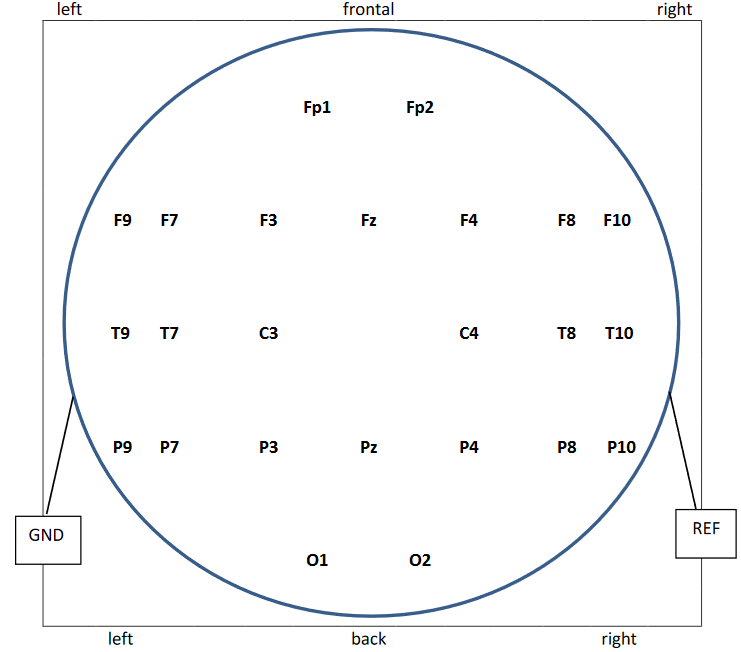
</div>

In [ ]:
# Standard Map laden und an Datensatz zufügen
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
fig = raw.plot_sensors(show_names=True)

In [ ]:
# Elektrodennummerierung (jede Elektrode hat eine eigene ID)
channels = pd.read_csv('electrode_info.csv')
channels = channels[1:25].reset_index()['electrodes']
channel_names = pd.DataFrame(channels, index=range(24))
channel_names['ID'] = range(24)
channel_names

### 3) Data viewing
Now we can take a first look at the data!Jetzt können wir einen ersten Blick auf die Daten werfen!

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Create a figure of the EEG data. Use the function <tt>plot_signal()</tt>, which takes the dataset (<tt>raw</tt>), a start and end time (in seconds), and electrode number(s) as parameters.
    Example:  <tt>plot_signal(raw, start=20, end=600, electrodes=[5, 21])</tt>. Consider the entire length of the data, and note electrodes that fluctuate strongly or show strong disturbances.
</div>

<div class='alert alert-success'>
    <b>Tip</b>: The electrodes are numbered. In the table above in the "Electrode montage mapping" section, you can see which ID belongs to which electrode. You can then enter these for the <tt>electrodes</tt> parameter in the <tt>plot_signal()</tt> function. Example: To display electrode F4 and P3, I enter the IDs 6 and 17 (<tt>electrodes=[6, 17]</tt>). With the command <tt>range(24)</tt> (instead of the square brackets), you can display all 24 electrodes at the same time.
</div>

In [ ]:
plot_signal(raw, start=..., end=..., electrodes=[..., ...])

Falls ihr eine Elektrode (oder mehrere) entdeckt die stark fluktuiert, notiert sie euch. Kanäle mit sehr schlechten Signal werden wir in einem späteren Schritt entfernen.

### 4) Frequency power spectrum
EEG data is composed of waves of different frequencies, as neurons in our brain send signals at different speeds and communicate with each other. Each frequency contributes differently to the overall power of brain activity. You have already learned that the **Fourier Transformation** can be applied to find out the amplitude of each frequency of the EEG signal. The resulting graph is also called the power spectrum.

In this part of the task, we want to find out which frequencies are present in our EEG data, and how strong each frequency is.
With the help of the so-called Fourier analysis, it is possible to find out the amplitudes (also called power spectrum density) of each frequency of the EEG signal. The resulting graph is also called the power spectrum.

In the following figure, you see what a typical EEG spectrum of cleaned data (and averaged across all electrodes) looks like:



<div>
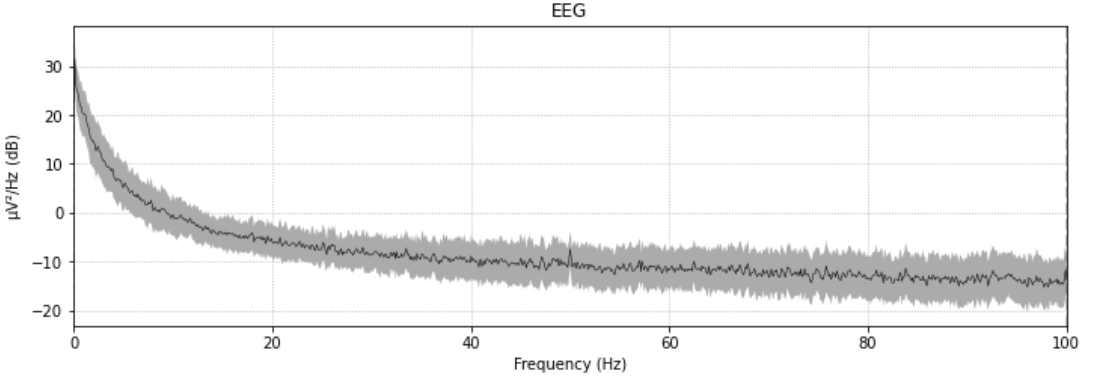
</div>


<div class='alert alert-warning'>
    <b>ToDo</b> (2 Punkte): Verwendet die `plot_psd()` Funktion (welche im Hintergrund die Fourier Transformation durchführt) um das Power Spektrum euer Daten zu berechnen, und gebt verschiedene Werte für `fmin` und `fmax` ein (niedrigste und höchste Frequenz). Vergleicht euer Spektrum mit dem obigen Beispiel und schreibt in euer Protokoll, wenn etwas nicht übereinstimmt (denkt daran: das obige Spektrum is ein mittelwert aus allen 24 Kanälen).
</div>

In [ ]:
raw.plot_psd(fmin=0, fmax=100)
plt.show()

### 5) Preprocessing
The activity measured with the EEG cap, unfortunately, does not represent pure brain activity. Since the electrodes in the cap are very sensitive, they also pick up any other changes in electrical potential.
We will remove the following noise factors step by step from the signal:

5.1) Preparations

5.2) Baseline Correction

5.3) Channels with Insufficient Signal

5.4) Power Lines

5.5) Eye Blinking, Heartbeat, and Other Muscle Interference Factors

#### 5.1) Preparation

First, perform downsampling of the data, so you reduce the data points - then processing goes faster!

In [ ]:
resample_freq = 200
_ = raw.resample(resample_freq)

Our experiment consists of two parts: the passive part where you fixed your gaze on the cross, and the active part where you added numbers together. Divide the data into these two sections - Passive and Active! The variables referring to the respective data sets from now on are called ```raw_passive``` (for the passive dataset) and ```raw_active``` (for the active dataset).

Also, delete the first and last 10 seconds, in case the participant moved. 

In [ ]:
raw_passive, raw_active = split_dataset(raw)

# Lösche die ersten und letzten 10 sekunden, da die Teilnehmer in der Zeit ihren Blick auf das Fixierungs-Kreuz gerichtet haben
start_time = 10
end_time = 290
_ = raw_passive.crop(tmin=start_time, tmax=end_time)
_ = raw_active.crop(tmin=start_time, tmax=end_time)

#### 5.2) Baseline Correction
Some channels/electrodes show different background activity due to movement or condition of the scalp (e.g., through sweating), causing the signals to be at different base levels (also called baseline). We want to bring them to the same baseline. Use the `detrend_baselines(raw)` function for this.


Example:

<div>
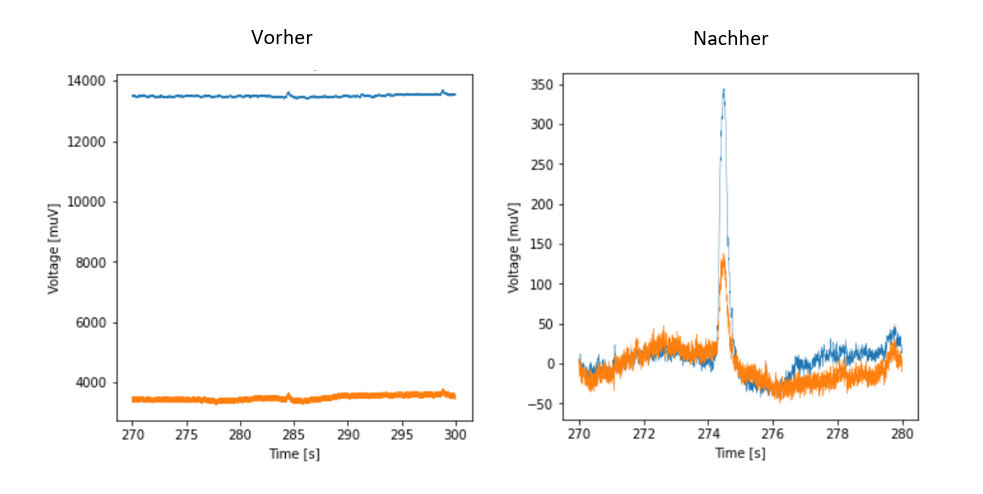
</div>



<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Apply the function <tt>detrend_baselines(raw)</tt> to adjust the activity around the baseline to 0 mV. Important: don't forget to apply it to both datasets (raw_passive AND raw_active)!
</div>

In [ ]:
# wende es erst auf das raw_passive Datenset
detrend_baselines(...)

# ... und dann auf das raw_active Datenset an
detrend_baselines(...)

In [ ]:
# Schaue dir an wie die Daten nach dem Verschieben der Baseline aussehen
plot_signal(raw_passive, electrodes=range(24))
plot_signal(raw_active, electrodes=range(24))

<div class='alert alert-success'>
    <b>Tip</b>: The signals of all channels are now approximately at the same level (around 0µV). This makes it easy to see if there are one or more channels that fluctuate strongly beyond the baseline. Find out which channels these are and write them down.
</div>

#### 5.3) Dealing with Channels with Insufficient Signal

It is possible that some electrodes/channels could not measure brain activity correctly and are unusable - with dry electrodes, it is normal for this to be about 20% of the channels. We need to find out which channels are affected to remove them from our dataset. You can use the `detect_bad_channels()` function for this. 



In [ ]:
detect_bad_channels(raw_passive)
detect_bad_channels(raw_active)

<div class='alert alert-warning'>
    <b>ToDo</b> (3 points): Note which channels were detected and check if these match the channels that you already noticed as insufficient during data collection. All electrodes you have noted should now be removed. Inform the program about which channels are involved. Fill in the list with the points <tt>[..., ...]</tt>.
    
Example: Type <tt>bad_channels_passive = ['F7', 'P10']</tt> to remove electrodes F7 and P10. Remember: it is common that 20% of all electrodes must be removed due to poor signal!
</div>

<div class='alert alert-success'>
    <b>Tip</b>: If you have not yet recorded your own experiment, delete the electrodes 'P4', 'F8', 'T10', and 'P7', which were assessed as insufficient during the measurement of the example dataset. Don't forget the results of the above function <tt>detect_bad_channels()</tt>!
</div>

In [ ]:
bad_channels_passive = ['T7', 'P4', 'F8', 'T10', 'P7']
bad_channels_active = ['T7', 'P4', 'F8', 'T10', 'P7']

In [ ]:
# Entferne die Elektroden 
raw_passive_elect = remove_bad_channels(bad_channels_passive, raw_passive)
raw_active_elect = remove_bad_channels(bad_channels_active, raw_active)

In [ ]:
plot_signal(raw_passive_elect, start=10, end=12, electrodes=range(24))
plot_signal(raw_active_elect, start=10, end=12, electrodes=range(24))

#### 5.4) Disturbances from Power Lines
While examining the Power Density Spectrum, you surely noticed a strong spike at 50Hz. These are the alternating current lines being recorded by the EEG electrodes. To get rid of this signal while removing as little of the measured brain activity as possible, we use the so-called **ZapLine Algorithm**. 



<div class='alert alert-warning'>
    <b>ToDo</b> (2 points): Use the `filter_line_power()` function to filter the signal. Adjust the `filter_strength` parameter depending on the strength of the noise signal. The higher the value, the stronger the filtering effect. However, a too high value can distort the data. Find the right value by directly looking at the power spectrum after filtering and check if the 50Hz artifact has really disappeared.
</div>

In [ ]:
# Verwende "dss_line()" für das "passive" Datenset ...
raw_passive_zapline = filter_line_power(raw_passive_elect, filter_stärke=...)

# ... und für das "aktive"
raw_active_zapline = filter_line_power(raw_active_elect, filter_stärke=...)

In [ ]:
# Kontrolliere das Ergebnis indem du das "neue" Power Spectrum plottest. Falls du noch einen Peak bei 50Hz siest, 
# erhöhe den Wert für "nremove" in der "dss_line()" Funktion und führe die Zelle erneut aus
raw_passive_zapline.plot_psd(0, 100)
plt.show()

raw_active_zapline.plot_psd(0, 100)
plt.show()

In [ ]:
# Filtere außerdem die 0.5Hz Leitung aus dem Signal
raw_passive_filtered = raw_passive_zapline.copy()
_ = raw_passive_filtered.filter(l_freq=1, h_freq=None)
raw_active_filtered = raw_active_zapline.copy()
_ = raw_active_filtered.filter(l_freq=1, h_freq=None)

#### 5.5) Eye Blinking, Heartbeat, and Other Muscle Interference Factors
In this section, we will track down interference factors such as eye blinking and heartbeat, for which we will use the so-called **Independent Component Analysis (ICA)**. This analysis method makes it possible to detect individual interference factors that are distributed across different channels.

In [ ]:
# Die Ausführung dieser Funktion kann etwas dauern 
raw_passive_cleaned = apply_ica(raw_passive_filtered)
raw_active_cleaned = apply_ica(raw_active_filtered)

Look at the data again. What changed? 

In [ ]:
plot_signal(raw_passive_cleaned, start=40, end=50, electrodes=range(24))
plot_signal(raw_active_cleaned, start=40, end=50, electrodes=range(24))


### 6) Calculation of Energy in Active and Passive State

Congratulations! You have successfully cleaned your data so that we can finally use it for analysis!

Our goal is to compare the **energy** for the passive (focusing on the fixation cross) and active (solving math tasks) experiment. For this, we need the power spectrum, which you have already worked on in section 4). For the energy calculation, we will use a function that integrates the power spectrum of the respective signal.

**IMPORTANT**: As you have already learned, the EEG signal is divided into different **frequency bands**:

<div>
<img src="brainwaves.png" width="450"/>
</div>

These frequency bands are differently pronounced in the brain in different cognitive states!

- **Alpha Band**: Strongly pronounced (high power) when the measured person is in a resting state, has no task, or even closes their eyes.
- **Gamma Band**: Pronounced (high power) when the measured person is concentrating, for example, focused on a task.

<div class='alert alert-warning'>
    <b>ToDo</b> (2 points): Use the function <tt>compare_energy_plot()</tt> to compare the energy of the active and passive session for the <b>Alpha Band</b> and the <b>Gamma Band</b>. What result do you expect? Do your expectations match your results?
</div>

<div class='alert alert-success'>
    <b>Tip</b>: For the frequency spectrum from 1-100Hz, it is entered as follows: <tt>frequency_band = [1,100]</tt>. For the Alpha and Gamma bands, you just need to adjust the numbers accordingly (see illustration)!
</div>

In [ ]:
# Vergleiche die Power im Alpha-Band
compare_energy_plot(raw_passive_cleaned, raw_active_cleaned, frequency_band=[..., ...])

In [ ]:
# Vergleiche die Power im Gamma-Band
compare_energy_plot(raw_passive_cleaned, raw_active_cleaned, frequency_band=[..., ...])

In [ ]:
# Power des gesamten Frequenzbereichs
compare_energy_plot(raw_passive_cleaned, raw_active_cleaned, frequency_band=[1, 100])


### 7) Topography
Lastly, we want to see how the frequencies we've looked at in the Power Spectrum (see section **4) Frequency Power Spectrum**) are distributed across the brain. The electrodes are distributed on the EEG cap in such a way that they can measure different areas of the brain. Since we've already linked the electrode positions to the measured data in the previous step (section **Montage Mapping**), we can now graphically represent the activity for the entire EEG cap.




<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Create a topography image of the <b>Alpha frequency band</b>. This image will show you in which parts of the brain the Alpha frequency occurs most strongly.
</div>

In [ ]:
frequency_band_topography(raw_passive_cleaned, frequeny_band=[...,...])